# Trabajo Práctico 3
Encuesta Permanente de Hogares (EPH) 

Integrantes: Regina Zasiekin Drittanti, Mila Palacios Vieira y Milagros Arjona

# Parte 1 : Analizando la base

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression


In [2]:
base_04_inicial = pd.read_stata('/Users/usuario/Downloads/Individual_t104(1).dta')  
base_24_inicial = pd.read_excel('/Users/usuario/Downloads/usu_individual_T124(3).xlsx')

a. Eliminen todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos Aires, y unan ambos trimestres en una sola base. 

In [3]:
# me quedo solo con los valores de CABA y GBA
base_04_filtrada = base_04_inicial.loc[base_04_inicial['aglomerado'].isin(['Ciudad de Buenos Aires', 'Partidos del GBA'])]
base_24_filtrada = base_24_inicial.loc[base_24_inicial['AGLOMERADO'].isin([32, 33])]

#Para poder unir sin problema, me aseguro que als variables esten en el mismo formato
base_04_filtrada.columns = base_04_filtrada.columns.str.lower()
base_24_filtrada.columns = base_24_filtrada.columns.str.lower()

# concateno las bases
union_eph = pd.concat([base_24_filtrada, base_04_filtrada])
print(union_eph.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'componente', 'h15', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp

Las columnas de interés de la base son: 
- CH04: Sexo
- CH06: Años
- CH07: Estado civil 
- CH08: Estado cobertura médica
- NIVEL_ED: Nivel educativo 
- ESTADO: Condicion de actividad
- CAT_INAC: Categoria de inactividad
- IPCF: Monto de ingreso per cápita familiar percibido en el mes de referencia

In [4]:
# como hay datos que tienen distintas etiquetas en las dos bases que concatenamos, tenemos que unificar renombrar las etiquetas de una de las bases asi se pueden tener todos los datos con el mismo valor
variables_interes = union_eph[["ch04", "ch06", "ch07", "ch08", "nivel_ed", "estado", "cat_inac"]]

for i in variables_interes:
    if i == "ch04": 
        union_eph['ch04'] = union_eph['ch04'].replace({
            'Mujer': 2,
            'Varón': 1})
    elif i == "ch06":
        union_eph['ch06'] = union_eph['ch06'].replace({
            '98 y más años' : 98, 
            'Menos de 1 año' : 0})
        # cambio el formato de los valores de esta columna porque la mitad estaba en float y la mitas en int
        union_eph['ch06'] = union_eph['ch06'].astype(int)
    elif i == "ch07":
        union_eph['ch07'] = union_eph['ch07'].replace({
            'Unido': 1, 
            'Casado': 2, 
            'Separado o divorciado': 3, 
            'Viudo': 4, 
            'Soltero': 5})
    elif i == "ch08":
        union_eph['ch08'] = union_eph['ch08'].replace({
            'Obra social (incluye PAMI)': 1,  
            'Mutual/Prepaga/Servicio de emergencia': 2,  
            'Planes y seguros públicos': 3,  
            'No paga ni le descuentan': 4,  
            'Ns./Nr.': 9,  
            'Obra social y mutual/prepaga/servicio de emergencia': 12,  
            'Obra social y planes y seguros públicos': 13,  
            'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23,
            'Obra Social, mutual/prepaga/servicio de emergencia y planes y seguros públicos': 123})
    elif i == "nivel_ed":
        union_eph['nivel_ed'] = union_eph['nivel_ed'].replace({
            1: 'Primaria Incompleta (incluye educación especial)',  
            2: 'Primaria Completa',  
            3: 'Secundaria Incompleta',  
            4: 'Secundaria Completa',  
            5: 'Superior Universitaria Incompleta',  
            6: 'Superior Universitaria Completa', 
            7: 'Sin instrucción',  
            9: 'Ns./ Nr. '})
    elif i == "estado":
        union_eph['estado'] = union_eph['estado'].replace({
            'Ocupado': 1,  
            'Desocupado': 2,  
            'Inactivo': 3,  
            'Menor de 10 años': 4,  
            'Entrevista individual no realizada (no respuesta al cuestion': 0})
    elif i == "cat_inac":
        union_eph['cat_inac'] = union_eph['cat_inac'].replace({
            0.0 : 0,
            'Jubilado/pensionado': 1,  
            'Rentista': 2,  
            'Estudiante': 3,  
            'Ama de casa': 4,  
            'Menor de 6 años': 5,  
            'Discapacitado': 6,  
            'Otros': 7})
    conteo = union_eph.groupby(i).size()

C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\1806660603.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  union_eph['ch04'] = union_eph['ch04'].replace({
C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\1806660603.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  union_eph['ch06'] = union_eph['ch06'].replace({
C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\1806660603.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly

b. Si hay observaciones con valores que no tienen sentido, descártenlas (por ejemplo, ingresos y edades negativos). Expliquen las decisiones tomadas. 

In [5]:
# Verificación de observaciones negativas en EDAD

valores_negativos_edad = union_eph['ch06'] < 0
# cantidad de datos negativos
cantidad_negativos_edad = valores_negativos_edad.sum()
print("Cantidad de valores negativos en variable edad:", cantidad_negativos_edad)

# me quedo con los valores mayores o iguales a 0 de edad
base_limpia = union_eph[union_eph['ch06'] >= 0]

# Verificación de observaciones negativas en IPCF
valores_negativos_ipcf = union_eph[union_eph['ipcf'] < 0]
# cantidad de datos negativos
cantidad_negativos_ipcf = len(valores_negativos_ipcf)
# Mostrar resultados
print("Cantidad de valores negativos en variable ipcf:", cantidad_negativos_ipcf)

# me quedo con los valores mayores o iguales a 0. Como no hay valores negativos, no saca ninguno
base_limpia = union_eph[union_eph['ipcf'] >= 0]

Cantidad de valores negativos en variable edad: 51
Cantidad de valores negativos en variable ipcf: 0


c. Una vez hecha esa limpieza, realicen un gráfico de barras mostrando la composición por sexo para 2004 y 2024. Comenten los resultados. 


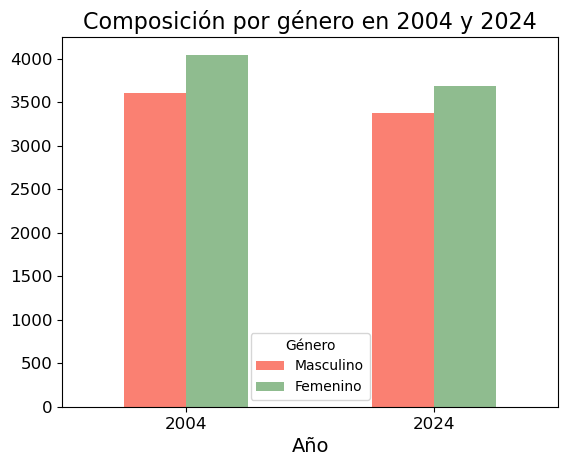

In [31]:
import matplotlib.pyplot as plt

# Convertir el año a entero
base_limpia['ano4'] = base_limpia['ano4'].astype(int)

# Agrupación por año y género
composicion = base_limpia.groupby(['ano4', 'ch04']).size().unstack(fill_value=0)

# Graficar
ax = composicion.plot(kind='bar', color=['salmon', 'darkseagreen'])
plt.title('Composición por género en 2004 y 2024', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Género', labels=['Masculino', 'Femenino'])
plt.show()



In [7]:
# Agrupación por año y género
composicion = base_limpia.groupby(['ano4', 'ch04']).size().unstack(fill_value=0)

# Mostrar la tabla de cantidad de cada género por cada año
print(composicion)

ch04     1     2
ano4            
2004  3602  4045
2024  3371  3680


d. Realicen una matriz de correlación para 2004 y 2024 con las siguientes variables: CH04, CH06, CH07, CH08, NIVEL ED, ESTADO, CAT_INAC, IPCF. Utilicen alguno de los comandos disponibles en este link o este link para graficar la matriz de correlación. Comenten los resultados.

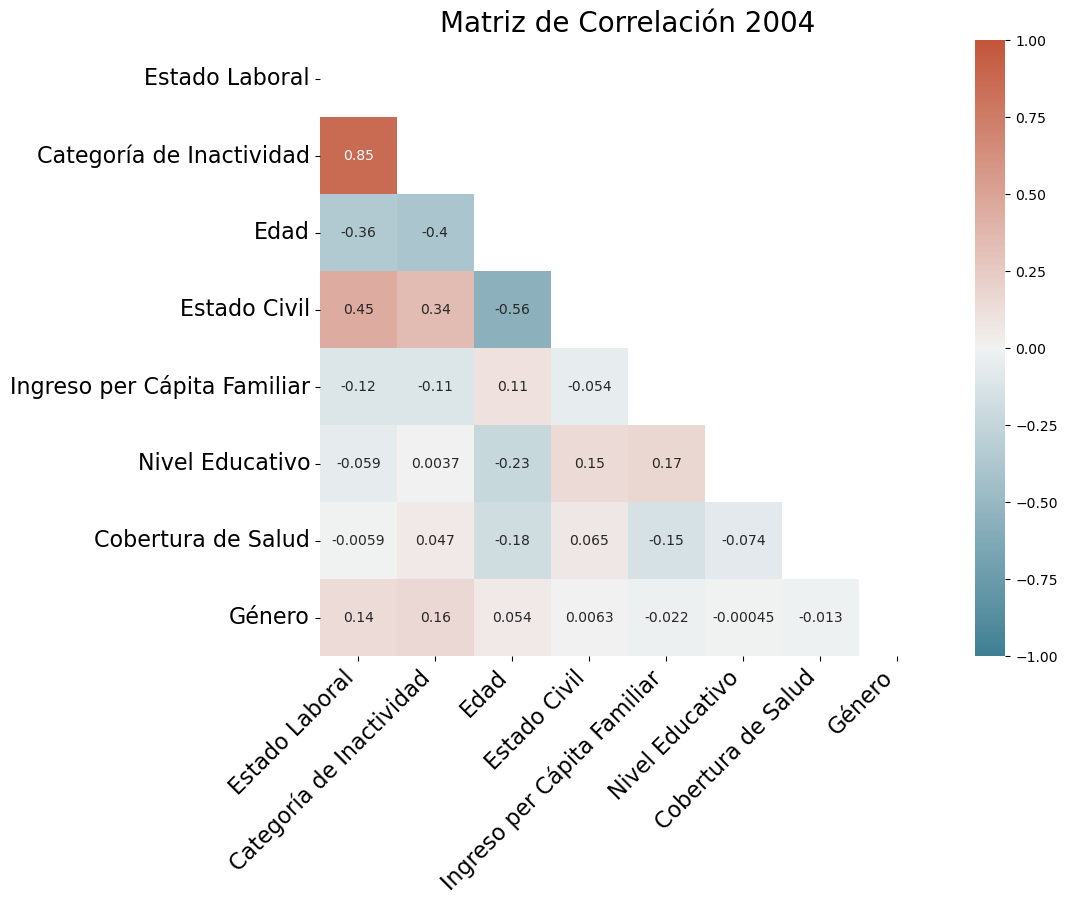

In [39]:
# Filtrar base_limpia para crear base04 con registros de 2004
base04 = base_limpia[base_limpia['ano4'] == 2004].copy()

# Filtrar base_limpia para crear base24 con registros de 2024
base24 = base_limpia[base_limpia['ano4'] == 2024].copy()

# Filtrar las columnas necesarias
variables = ['ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'estado', 'cat_inac', 'ipcf']
eph_2004_filtered = base04[variables].copy()  # Asegúrate de que base04 tenga datos cargados
eph_2024_filtered = base24[variables].copy()  # Asegúrate de que base24 tenga datos cargados

# Convertir columnas categóricas a numéricas para el año 2004
categorical_columns = ['ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'estado', 'cat_inac']
for col in categorical_columns:
    eph_2004_filtered[col] = eph_2004_filtered[col].astype('category').cat.codes

# Calcular la matriz de correlación para el año 2004
corr_2004 = eph_2004_filtered.corr()

# Ordenar las variables por la suma absoluta de la correlación
abs_corr_sum_2004 = corr_2004.abs().sum().sort_values(ascending=False)
ordered_corr_2004 = corr_2004.loc[abs_corr_sum_2004.index, abs_corr_sum_2004.index]

# Diccionario con nombres claros para las variables
nombres_claros = {
    'ch04': 'Género',
    'ch06': 'Edad',
    'ch07': 'Estado Civil',
    'ch08': 'Cobertura de Salud',
    'nivel_ed': 'Nivel Educativo',
    'estado': 'Estado Laboral',
    'cat_inac': 'Categoría de Inactividad',
    'ipcf': 'Ingreso per Cápita Familiar'
}

# Renombrar las filas y columnas en la matriz de correlación ordenada
ordered_corr_2004.rename(index=nombres_claros, columns=nombres_claros, inplace=True)

# Graficar la matriz de correlación para 2004
plt.figure(figsize=(10, 8))
mask_2004 = np.triu(np.ones_like(ordered_corr_2004, dtype=bool))  # Máscara para la mitad superior
sns.heatmap(
    ordered_corr_2004,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),  # Paleta de colores azul-rosa
    annot=True, mask=mask_2004, square=True
)
plt.title("Matriz de Correlación 2004", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)  # Aumentar tamaño de fuente para etiquetas del eje x
plt.yticks(fontsize=16)  # Aumentar tamaño de fuente para etiquetas del eje y
plt.show()




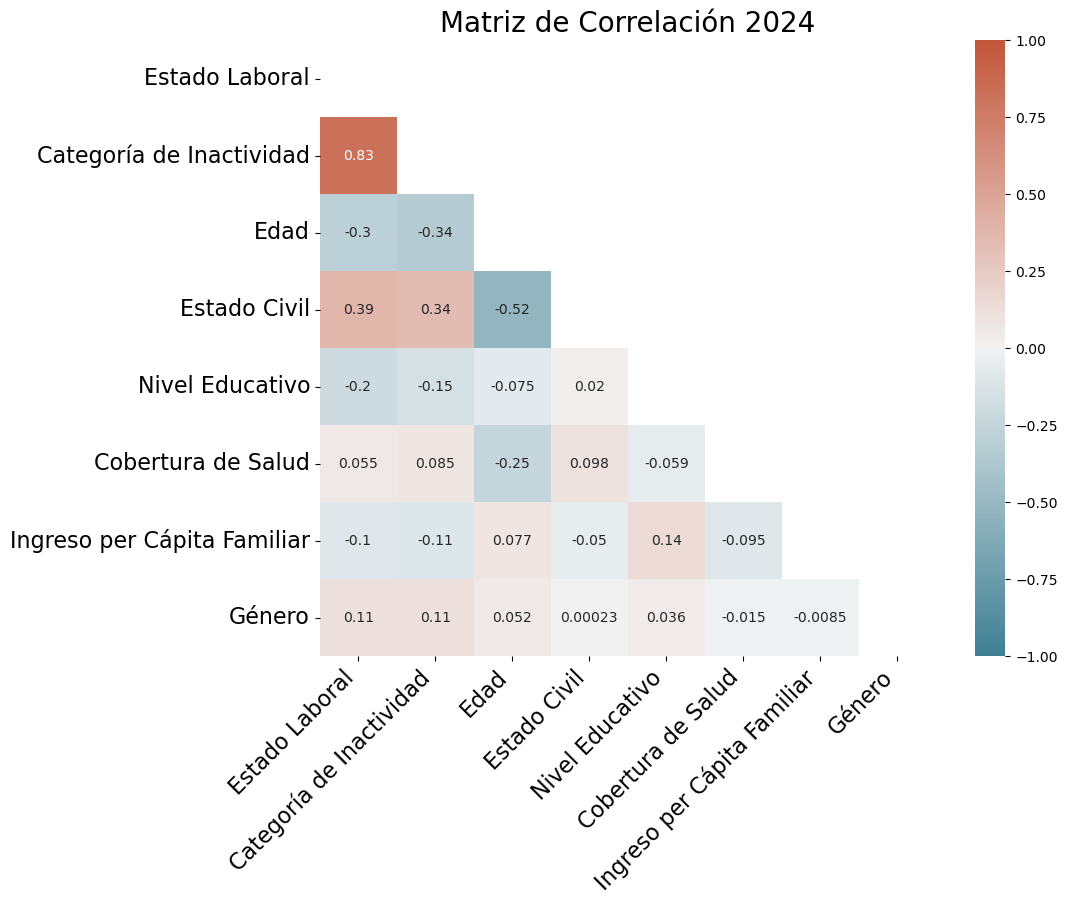

In [40]:
# Filtrar base_limpia para crear base24 con registros de 2024
base24 = base_limpia[base_limpia['ano4'] == 2024].copy()

# Filtrar las columnas necesarias
eph_2024_filtered = base24[variables].copy()  # Asegúrate de que base24 tenga datos cargados

# Convertir columnas categóricas a numéricas para el año 2024
for col in categorical_columns:
    eph_2024_filtered[col] = eph_2024_filtered[col].astype('category').cat.codes

# Calcular la matriz de correlación para el año 2024
corr_2024 = eph_2024_filtered.corr()

# Ordenar las variables por la suma absoluta de la correlación
abs_corr_sum_2024 = corr_2024.abs().sum().sort_values(ascending=False)
ordered_corr_2024 = corr_2024.loc[abs_corr_sum_2024.index, abs_corr_sum_2024.index]

# Renombrar las filas y columnas en la matriz de correlación ordenada
ordered_corr_2024.rename(index=nombres_claros, columns=nombres_claros, inplace=True)

# Graficar la matriz de correlación para 2024
plt.figure(figsize=(10, 8))
mask_2024 = np.triu(np.ones_like(ordered_corr_2024, dtype=bool))  # Máscara para la mitad superior
sns.heatmap(
    ordered_corr_2024,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),  # Paleta de colores azul-rosa
    annot=True, mask=mask_2024, square=True
)

plt.title("Matriz de Correlación 2024", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)  # Aumentar tamaño de fuente para etiquetas del eje x
plt.yticks(fontsize=16)  # Aumentar tamaño de fuente para etiquetas del eje y
plt.show()

e. ¿Cuántos desocupados hay en la muestra? ¿Cuántos inactivos? ¿Cuál es la media de ingreso per cápita familiar (IPCF) según estado (ocupado, desocupado, inactivo)?

In [10]:
# e. 

# ¿Cuántos desocupados hay en la muestra? ¿Cuántos inactivos?
cantidad_desocupados = (base_limpia['estado'] == 2).sum()
print(f"Cantidad de desocupados: {cantidad_desocupados}")

cantidad_inactivos = (base_limpia['estado'] == 3).sum()
print(f"Cantidad de inactivos: {cantidad_inactivos}")

# ¿Cuál es la media de ingreso per cápita familiar (IPCF) según estado (ocupado, desocupado, inactivo)?
media_ipcf_ocupados = base_limpia[base_limpia['estado'] == 1]['ipcf'].mean()
print(f"Media de IPCF para ocupados: {media_ipcf_ocupados}")

media_ipcf_desocupados = base_limpia[base_limpia['estado'] == 2]['ipcf'].mean()
print(f"Media de IPCF para desocupados: {media_ipcf_desocupados}")

media_ipcf_inactivos = base_limpia[base_limpia['estado'] == 3]['ipcf'].mean()
print(f"Media de IPCF para inactivos: {media_ipcf_inactivos}")


Cantidad de desocupados: 839
Cantidad de inactivos: 5462
Media de IPCF para ocupados: 106443.40482000724
Media de IPCF para desocupados: 31655.95795031151
Media de IPCF para inactivos: 63863.08062739541


# Punto 3

Uno de los grandes problemas de la EPH es la creciente cantidad de hogares que no reportan sus ingresos (ver por ejemplo el siguiente
informe). 

¿Cuántas personas no respondieron cuál es su condición de actividad? 

Guarden como una base distinta llamada "RESPONDIERON" las observaciones donde respondieron la pregunta sobre su condición de actividad (ESTADO). 

Las observaciones con ESTADO=0 guárdenlas en una base bajo el nombre NORESPONDIERON

In [11]:
norespondieron = base_limpia[base_limpia['estado'] == 0]
respondieron = base_limpia[base_limpia['estado'] != 0]

# Contar las observaciones en cada grupo
cantidad_no_respondieron = norespondieron.shape[0]
cantidad_respondieron = respondieron.shape[0]

# Resultados
print(f"Cantidad de personas que no respondieron su condición de actividad: {cantidad_no_respondieron}")
print(f"Cantidad de personas que sí respondieron su condición de actividad: {cantidad_respondieron}")

# Si quieres guardar las bases como archivos CSV (opcional)
respondieron.to_csv('respondieron.csv', index=False)
norespondieron.to_csv('norespondieron.csv', index=False)


Cantidad de personas que no respondieron su condición de actividad: 51
Cantidad de personas que sí respondieron su condición de actividad: 14647


# Punto 4

Agreguen a la base respondieron una columna llamada PEA (Población Económicamente Activa) que tome 1 si están ocupados o desocupados en ESTADO. 

Realicen un gráfico de barras mostrando la composición por PEA para 2004 y 2024. Comenten los resultados.

In [12]:
respondieron['PEA'] = respondieron['estado'].apply(lambda x: 1 if x in [1, 2] else 0)

C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\4151605928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['PEA'] = respondieron['estado'].apply(lambda x: 1 if x in [1, 2] else 0)


In [13]:
# Filtrar los datos para el año 2004
respondieron_2004 = respondieron[respondieron['ano4'] == 2004]

# Filtrar los datos para el año 2024
respondieron_2024 = respondieron[respondieron['ano4'] == 2024]

# Contar cuántos valores de PEA son 1 en 2004
count_pea_2004 = (respondieron_2004['PEA'] == 1).sum()

# Contar cuántos valores de PEA son 1 en 2024
count_pea_2024 = (respondieron_2024['PEA'] == 1).sum()

# Mostrar los resultados
print("Cantidad de PEA = 1 para 2004:", count_pea_2004)
print("Cantidad de PEA = 1 para 2024:", count_pea_2024)


Cantidad de PEA = 1 para 2004: 3607
Cantidad de PEA = 1 para 2024: 3535


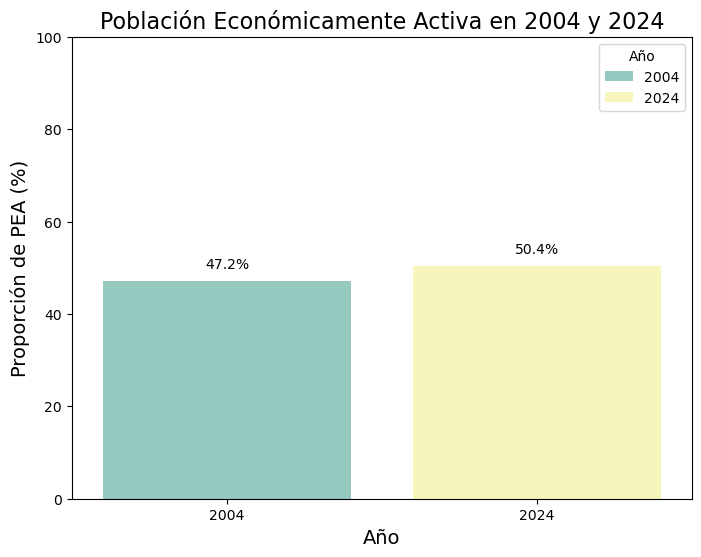

In [44]:
# Filtrar los datos para el año 2004
respondieron_2004 = respondieron[respondieron['ano4'] == 2004]
pea_2004 = (respondieron_2004['PEA'] == 1).mean() * 100  # Convertir a porcentaje

# Filtrar los datos para el año 2024
respondieron_2024 = respondieron[respondieron['ano4'] == 2024]
pea_2024 = (respondieron_2024['PEA'] == 1).mean() * 100  # Convertir a porcentaje

# Crear un DataFrame para facilitar la visualización
pea_data = pd.DataFrame({
    'Año': [2004, 2024],
    'Proporción PEA (%)': [pea_2004, pea_2024]})

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(data=pea_data, x='Año', y='Proporción PEA (%)', hue='Año', palette='Set3', dodge=False)
plt.title('Población Económicamente Activa en 2004 y 2024', fontsize = 16)


plt.xlabel('Año', fontsize = 14)
plt.ylabel('Proporción de PEA (%)', fontsize = 14)  # Añadir el símbolo de porcentaje
plt.ylim(0, 100)  # Ajustar el límite del eje y de 0 a 100

# Añadir las etiquetas de porcentaje sobre las barras
for i, value in enumerate(pea_data['Proporción PEA (%)']):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom')  # Etiqueta sobre la barra, ajustar el espacio

plt.show()



# Punto 5

Agreguen a la base respondieron una columna llamada PET (Población en Edad para Trabajar) que tome 1 si están la persona tiene
entre 15 y 65 años cumplidos. 

Realicen un gráfico de barras mostrando la composición por PEA para 2004 y 2024. Comenten los resultados y compare PET con PEA.

In [15]:
respondieron['PET'] = respondieron['ch06'].apply(lambda x: 1 if 15 <= x <= 65 else 0)

C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\648790860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['PET'] = respondieron['ch06'].apply(lambda x: 1 if 15 <= x <= 65 else 0)


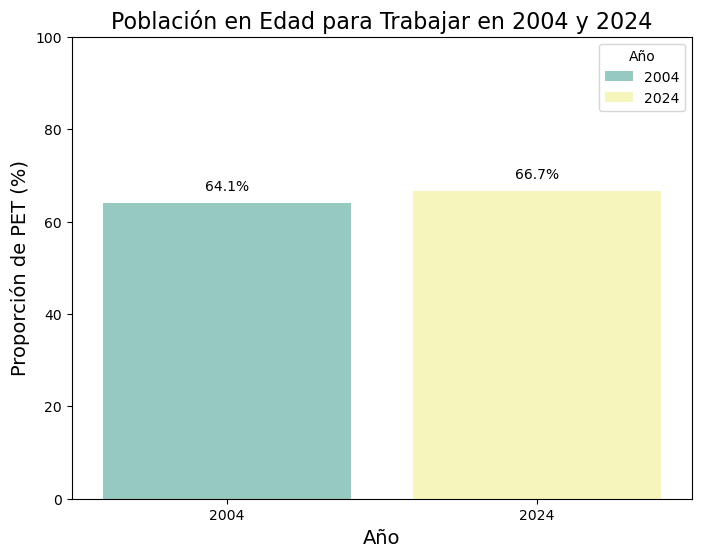

In [48]:
# Filtrar los datos para el año 2004
respondieron_2004 = respondieron[respondieron['ano4'] == 2004]
pet_2004 = (respondieron_2004['PET'] == 1).mean() * 100  # Convertir a porcentaje

# Filtrar los datos para el año 2024
respondieron_2024 = respondieron[respondieron['ano4'] == 2024]
pet_2024 = (respondieron_2024['PET'] == 1).mean() * 100  # Convertir a porcentaje

# Crear un DataFrame para facilitar la visualización
pet_data = pd.DataFrame({
    'Año': [2004, 2024],
    'Proporción PET (%)': [pet_2004, pet_2024]})

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(data=pet_data, x='Año', y='Proporción PET (%)', hue='Año', palette='Set3', dodge=False)
plt.title('Población en Edad para Trabajar en 2004 y 2024', fontsize = 16)
plt.xlabel('Año', fontsize = 14)
plt.ylabel('Proporción de PET (%)', fontsize = 14)  # Añadir el símbolo de porcentaje
plt.ylim(0, 100)  # Ajustar el límite del eje y de 0 a 100

# Añadir las etiquetas de porcentaje sobre las barras
for i, value in enumerate(pet_data['Proporción PET (%)']):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom')  # Etiqueta sobre la barra, ajustar el espacio

plt.show()



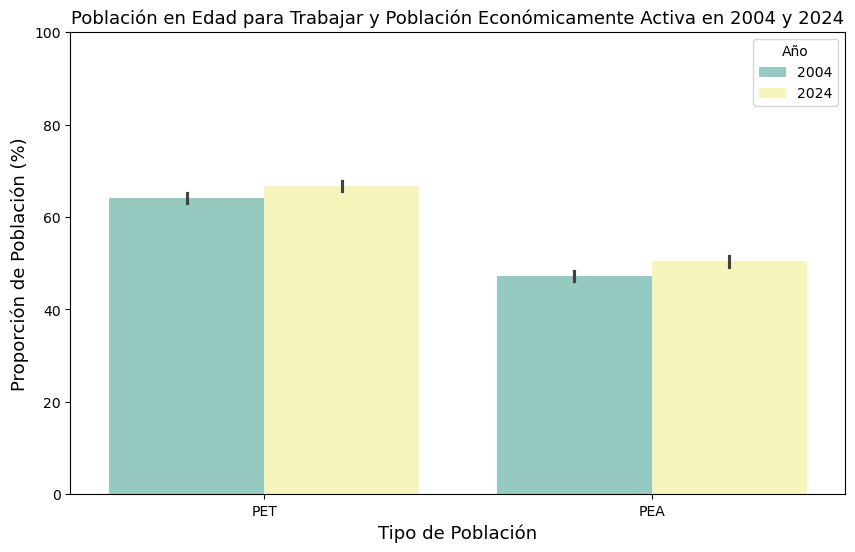

In [53]:
# Crear un DataFrame en formato largo para comparar PET y PEA, multiplicando para tener porcentajes
data_long = pd.melt(respondieron, 
                    id_vars='ano4', 
                    value_vars=['PET', 'PEA'],
                    var_name='Población', 
                    value_name='Proporción de Población')

# Convertir la proporción a porcentaje
data_long['Proporción de Población (%)'] = data_long['Proporción de Población'] * 100

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=data_long, x='Población', y='Proporción de Población (%)', hue='ano4', palette='Set3')
plt.title('Población en Edad para Trabajar y Población Económicamente Activa en 2004 y 2024', fontsize = 13)
plt.xlabel('Tipo de Población', fontsize = 13)
plt.ylabel('Proporción de Población (%)', fontsize = 13)  # Etiqueta con el símbolo de porcentaje
plt.legend(title='Año')
plt.ylim(0, 100)  # Limitar el eje y de 0 a 100
plt.show()


# Punto 6

Por ultimo, agreguen la base respondieron una columna llamada desocupado que tome 1 si esta desocupada. ¿Cuántas personas están
desocupadas en 2004 vs 2024?

In [18]:
respondieron['desocupado'] = respondieron['estado'].apply(lambda x: 1 if x == 2 else 0)

C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\1856332790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['desocupado'] = respondieron['estado'].apply(lambda x: 1 if x == 2 else 0)


Cantidad de Desocupados para 2004: 528
Cantidad de Desocupados para 2024: 311


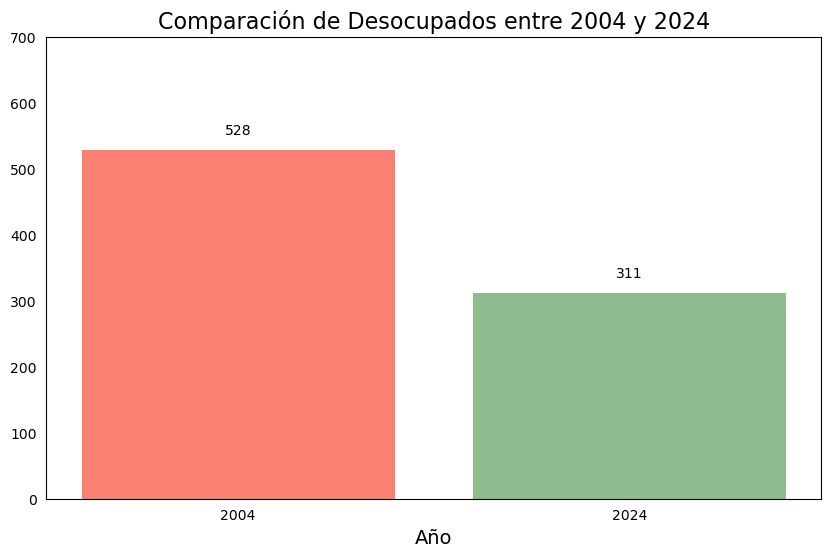

In [57]:
# Filtrar los datos para los años 2004 y 2024
respondieron_2004 = respondieron[respondieron['ano4'] == 2004]
respondieron_2024 = respondieron[respondieron['ano4'] == 2024]

# Contar cuántos valores de desocupados (PEA == 1) hay en 2004 y 2024
count_pea_2004_des = (respondieron_2004['desocupado'] == 1).sum()
count_pea_2024_des = (respondieron_2024['desocupado'] == 1).sum()

# Calcular el porcentaje de PET para 2004
pet_2004_percentage = (respondieron_2004['PET'] == 1).mean() * 100  # Convertir a porcentaje

# Mostrar los resultados
print("Cantidad de Desocupados para 2004:", count_pea_2004_des)
print("Cantidad de Desocupados para 2024:", count_pea_2024_des)

# Crear un gráfico de barras para comparar la cantidad de desocupados entre 2004 y 2024
years = ['2004', '2024']
pea_counts = [count_pea_2004_des, count_pea_2024_des]

plt.figure(figsize=(10, 6))
plt.bar(years, pea_counts, color=['salmon', 'darkseagreen'])
plt.title('Comparación de Desocupados entre 2004 y 2024', fontsize = 16)
plt.xlabel('Año', fontsize = 14)

# Establecer el límite superior del eje y en 700
plt.ylim(0, 700)

# Quitar las líneas del eje x e y para una apariencia más limpia
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

# Añadir etiquetas en las barras para mostrar los valores
for i, count in enumerate(pea_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')  # Ajustar el espacio para la etiqueta

plt.show()


a. (Opcional) Muestre la proporción de desocupados por nivel educativo comparando 2004 vs 2024. ¿Hubo cambios de
desocupados por nivel educativo?


In [20]:
# Calcular la proporción de desocupados por nivel educativo en 2004 y multiplicar por 100 para obtener el porcentaje
proporcion_desocupados_2004 = (respondieron_2004.groupby('nivel_ed')['desocupado'].mean() * 100  )

# Calcular la proporción de desocupados por nivel educativo en 2024 y multiplicar por 100 para obtener el porcentaje
proporcion_desocupados_2024 = (respondieron_2024.groupby('nivel_ed')['desocupado'].mean() * 100 ) 

# Crear un DataFrame para comparar las proporciones entre los años
comparacion_desocupados = pd.DataFrame({
    '2004 (%)': proporcion_desocupados_2004,
    '2024 (%)': proporcion_desocupados_2024})

# Mostrar los resultados de proporciones en porcentaje
print("Proporción de desocupados por nivel educativo en el año 2004 y 2024 (en %):")
print(comparacion_desocupados)

Proporción de desocupados por nivel educativo en el año 2004 y 2024 (en %):
                                                   2004 (%)  2024 (%)
nivel_ed                                                             
Primaria Completa                                  6.584615  4.729730
Primaria Incompleta (incluye educación especial)   3.060498  0.230947
Secundaria Completa                               12.650046  8.119925
Secundaria Incompleta                              7.798834  3.917379
Sin instrucción                                    0.372671  0.000000
Superior Universitaria Completa                    5.564142  2.540835
Superior Universitaria Incompleta                 13.571429  6.971429


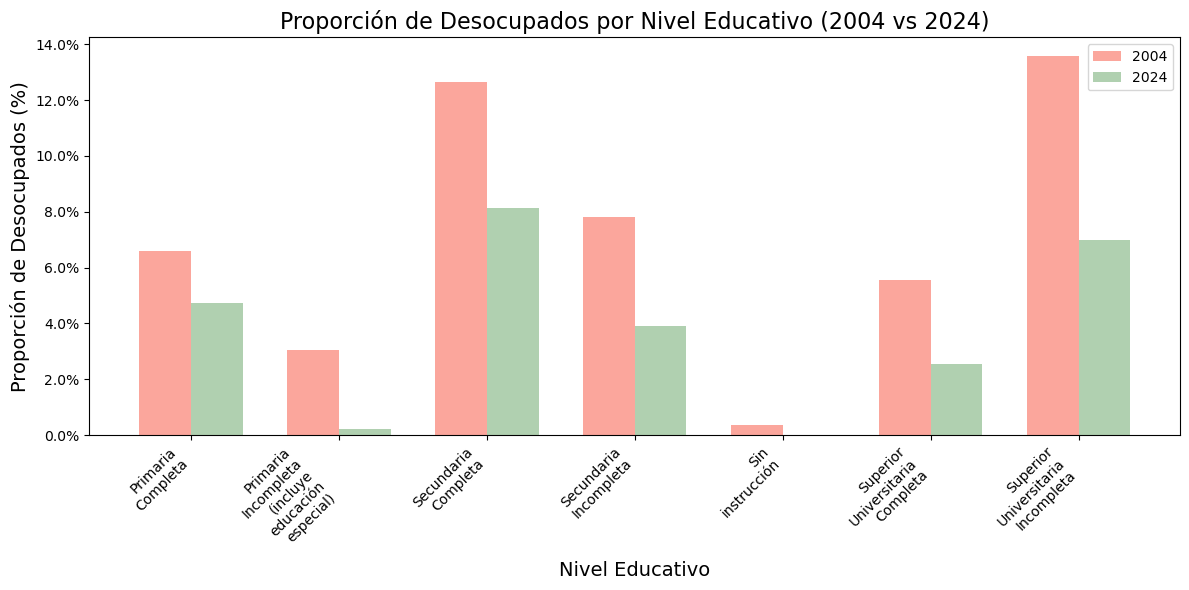

In [59]:
# Crear un DataFrame para facilitar la visualización
df_comparacion = pd.DataFrame({
    '2004': proporcion_desocupados_2004,
    '2024': proporcion_desocupados_2024
})

# Resetear el índice para usar NIVEL_ED como columna
df_comparacion.reset_index(inplace=True)

# Renombrar la columna para facilitar la visualización
df_comparacion.rename(columns={'nivel_ed': 'Nivel Educativo'}, inplace=True)

# Configurar el gráfico
plt.figure(figsize=(12, 6))
bar_width = 0.35  # Ancho de las barras
index = range(len(df_comparacion))  # Índices para las barras

# Crear barras para 2004 y 2024
bars_2004 = plt.bar(index, df_comparacion['2004'], bar_width, label='2004', alpha=0.7, color='salmon')
bars_2024 = plt.bar([i + bar_width for i in index], df_comparacion['2024'], bar_width, label='2024', alpha=0.7, color='darkseagreen')

# Añadir detalles al gráfico
plt.title('Proporción de Desocupados por Nivel Educativo (2004 vs 2024)', fontsize = 16)
plt.xlabel('Nivel Educativo', fontsize = 14)
plt.ylabel('Proporción de Desocupados (%)', fontsize = 14)

# Ajustar las etiquetas del eje x para que estén en ángulo y se muestren completas
plt.xticks(
    [i + bar_width / 2 for i in index],  # Posición centrada
    df_comparacion['Nivel Educativo'].str.replace(' ', '\n', regex=False),  # Reemplazar espacio con salto de línea
    rotation=45, ha='right'  # Rotación de las etiquetas a 45 grados y alineación a la derecha
)

# Formatear el eje Y como porcentaje
plt.gca().yaxis.set_major_formatter(PercentFormatter())

# Añadir la leyenda y ajustar el diseño para evitar solapamientos
plt.legend()
plt.tight_layout()  
plt.show()




b. (Opcional) Cree una variable categórica de años cumplidos (CH06) agrupada de a 10 años. Muestre proporción de desocupados por
edad agrupada comparando 2004 vs 2024. ¿Hubo cambios de desocupados por edad?

C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\3869038167.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['edad_agrupada'] = respondieron['ch06'].apply(clasificar_edad)


  Edad agrupada  Proporción 2004  Proporción 2024
0         10-19        17.234848        11.575563
1         20-29        35.984848        36.655949
2         30-39        16.287879        13.826367
3         40-49        10.037879        19.292605
4         50-59        12.500000        10.610932
5         60-69         6.250000         6.752412
6         70-79         1.515152         1.286174
7         80-89         0.189394         0.000000


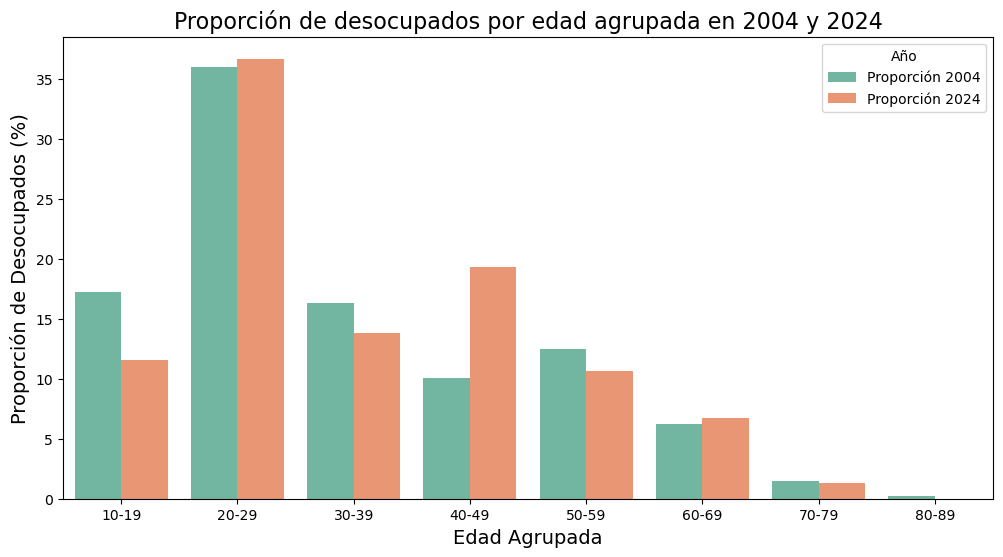

In [60]:
# Definir la función para clasificar la edad en intervalos de 10 años
def clasificar_edad(edad):
    if edad < 10:
        return '0-9'
    elif edad < 20:
        return '10-19'
    elif edad < 30:
        return '20-29'
    elif edad < 40:
        return '30-39'
    elif edad < 50:
        return '40-49'
    elif edad < 60:
        return '50-59'
    elif edad < 70:
        return '60-69'
    elif edad < 80:
        return '70-79'
    elif edad < 90:
        return '80-89'
    elif edad < 100:
        return '90-99'
    else:
        return '100+'

# Aplicar la función para clasificar la edad en el DataFrame 'respondieron'
respondieron['edad_agrupada'] = respondieron['ch06'].apply(clasificar_edad)

# Filtrar los datos para los años 2004 y 2024
respondieron_2004 = respondieron[respondieron['ano4'] == 2004]
respondieron_2024 = respondieron[respondieron['ano4'] == 2024]

# Calcular la proporción de desocupados por edad agrupada para cada año
proporciones_2004 = (
    respondieron_2004[respondieron_2004['estado'] == 2]['edad_agrupada']
    .value_counts(normalize=True) * 100
).reset_index()

proporciones_2024 = (
    respondieron_2024[respondieron_2024['estado'] == 2]['edad_agrupada']
    .value_counts(normalize=True) * 100
).reset_index()

# Renombrar columnas para claridad
proporciones_2004.columns = ['Edad agrupada', 'Proporción 2004']
proporciones_2024.columns = ['Edad agrupada', 'Proporción 2024']

# Unir las dos proporciones en un solo DataFrame
proporciones = pd.merge(proporciones_2004, proporciones_2024, on='Edad agrupada', how='outer').fillna(0)
print(proporciones)

# Transformar el DataFrame a formato largo para la visualización
proporciones_long = pd.melt(proporciones, id_vars='Edad agrupada', 
                            value_vars=['Proporción 2004', 'Proporción 2024'],
                            var_name='Año', value_name='Proporción de Desocupados')

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=proporciones_long, x='Edad agrupada', y='Proporción de Desocupados', hue='Año', palette='Set2')
plt.title('Proporción de desocupados por edad agrupada en 2004 y 2024', fontsize = 16)
plt.xlabel('Edad Agrupada', fontsize = 14)
plt.ylabel('Proporción de Desocupados (%)', fontsize = 14)
plt.legend(title='Año')
plt.show()


# Parte II - CLASIFICACION

El objetivo de esta parte del trabajo es intentar predecir si una persona está desocupada o no utilizando distintas variables de características individuales.

# Punto 1 

Para cada año, partan la base respondieron en una base de prueba (test) y una de entrenamiento (train) utilizando el comando
train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 101.
Establezca a desocupado como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables serán las variables
independientes (matriz X). Recuerden agregar la columna de unos (1).

[2 6 1 4 3 7 5]


C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\1906017227.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  respondieron['nivel_ed'] = respondieron['nivel_ed'].replace({"Primaria Incompleta (incluye educación especial)": 1,
C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\1906017227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['nivel_ed'] = respondieron['nivel_ed'].replace({"Primaria Incompleta (incluye educación especial)": 1,


C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\4158315355.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  norespondieron['nivel_ed'] = norespondieron['nivel_ed'].replace({"Primaria Incompleta (incluye educación especial)": 1,
C:\Users\usuario\AppData\Local\Temp\ipykernel_3348\4158315355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norespondieron['nivel_ed'] = norespondieron['nivel_ed'].replace({"Primaria Incompleta (incluye educación especial)": 1,


Año 2004:
X_train: (5345, 183)
X_test: (2292, 183)
y_train: (5345,)
y_test: (2292,)


Año 2024:
X_train: (4907, 183)
X_test: (2103, 183)
y_train: (4907,)
y_test: (2103,)




# Punto 2

Implementen los siguientes métodos reportando luego la matriz de confusión, la curva ROC, los valores de AUC y de Accuracy de cada uno:

● Regresión logística

● Análisis discriminante lineal

● KNN con k=3

● Naive Bayes


Resultados para el año 2004:

Logistic Regression:
  Matriz de Confusión:
[[4138    0]
 [ 257    0]]
  ROC AUC: 0.671
  Accuracy: 0.942

Linear Discriminant Analysis:
  Matriz de Confusión:
[[4110   28]
 [ 255    2]]
  ROC AUC: 0.969
  Accuracy: 0.936

Naive Bayes:
  Matriz de Confusión:
[[4138    0]
 [ 257    0]]
  ROC AUC: 0.708
  Accuracy: 0.942

K-Nearest Neighbors (k=3):
  Matriz de Confusión:
[[4073   65]
 [ 222   35]]
  ROC AUC: 0.719
  Accuracy: 0.935



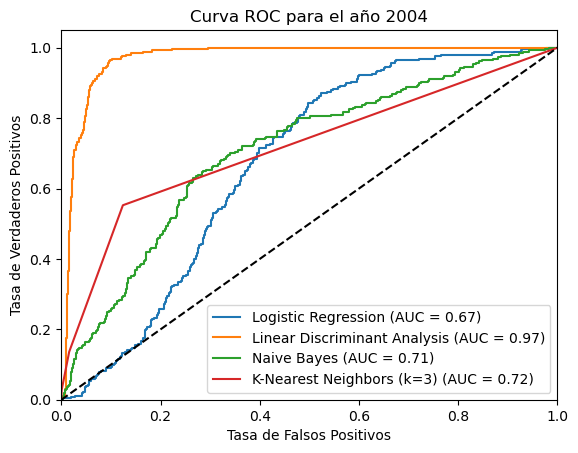


Resultados para el año 2024:

Logistic Regression:
  Matriz de Confusión:
[[2019    0]
 [  84    0]]
  ROC AUC: 0.651
  Accuracy: 0.960

Linear Discriminant Analysis:
  Matriz de Confusión:
[[2013    6]
 [  82    2]]
  ROC AUC: 0.972
  Accuracy: 0.958

Naive Bayes:
  Matriz de Confusión:
[[2019    0]
 [  84    0]]
  ROC AUC: 0.703
  Accuracy: 0.960

K-Nearest Neighbors (k=3):
  Matriz de Confusión:
[[1997   22]
 [  76    8]]
  ROC AUC: 0.592
  Accuracy: 0.953



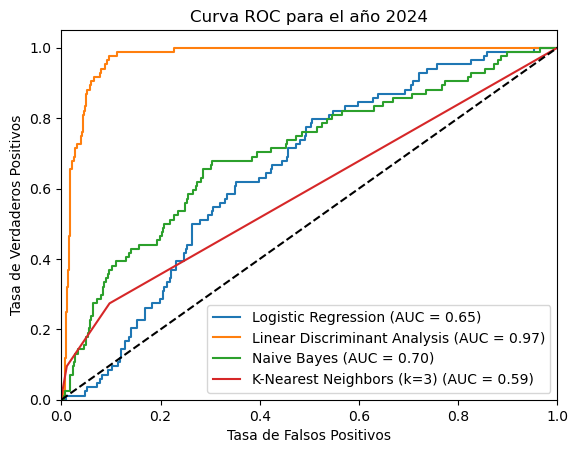

In [27]:
#Resolución 

# Punto 3

Compare los resultados de 2004 versus 2024. ¿Cuál de los métodos predice mejor en cada año? Justifiquen detalladamente utilizando las
medidas de precisión que conocen.

In [99]:
#Resolución

Resultados para 2004:
  Mejor modelo según AUC: Linear Discriminant Analysis (AUC = 0.969)
  Mejor modelo según Accuracy: Logistic Regression (Accuracy = 0.942)

Resultados para 2024:
  Mejor modelo según AUC: Linear Discriminant Analysis (AUC = 0.972)
  Mejor modelo según Accuracy: Logistic Regression (Accuracy = 0.960)



# Punto 4

Con el método que seleccionaron, predigan qué personas son desocupadas dentro de la base norespondieron. ¿Qué proporción de las personas que no respondieron pudieron identificar como desocupadas?

In [100]:
#Resolución 


Exactitud en el conjunto de prueba de `respondieron`: 93.92%
Proporción de personas en `norespondieron` identificadas como desocupadas: 17.65%
Total de personas identificadas como desocupadas: 9 de 51
